### Maxwell-Boltzmann Distribution

In [1]:
import numpy as np
import scipy as sy
from numba import jit # optional to speed up code; comment out if not installed

Define a function to create a set a randomly distributed particles.

In [2]:
def initial_conditions(nparticles, box_width, v0):
    
    # create array of random numbers for position of each particle
    positions = np.random.uniform(low=0, high=box_width, size=(nparticles, 2))

    # create array of zeros for the initial velocity of each particle
    velocities = np.random.uniform(low=-v0, high=v0, size=(nparticles, 2))
    
    return positions, velocities

Define a function to apply classical dynamics for a single time step $dt$.

In [183]:
@jit(nopython=True) # comment out this line if numba not installed
def classical_step(positions, velocities, dt, box_width):
    
    # define the critical distance of interaction
    crit_distance = 0.01
    
    # update the position of each particle
    positions = positions + velocities*dt  
    
    # check for particle-wall collisions
    for i in range(0, len(positions[:,0])):
        # examine x and y components of position
        for j in range(0, 2):
            # check if updated x/y position is outside of box
            if positions[i, j] < 0:
                positions[i, j] = -positions[i, j] # reflect position about lower boundary
                velocities[i, j] = -velocities[i, j] # change sign of velocity
            elif positions[i, j] > box_width:
                positions[i, j] = 2*box_width - positions[i, j] # reflect position about upper boundary
                velocities[i, j] = -velocities[i, j] # change sign of velocity
    
    # check for particle-particle collisions
    prev_velocities = velocities.copy() # copy of velocities before considering interactions
    ninteractions = velocities.copy()*0 # count number of interactions
    
    for i in range(0, len(positions[:,0])):
        # examine each pair of potential particle collisions
        for k in range(i + 1, len(positions[:,0])):
            # calculate the distance between the (i,k) pair of particles 
            distance = np.sqrt((positions[i, 0] - positions[k, 0])**2 + (positions[i, 1] - positions[k, 1])**2)
            
            # test if particles are within some critical distance of each other
            if distance < crit_distance*box_width:
                # apply conservation of momentum and energy (for equal mass particles)
                for j in range(0, 2):                
                    velocities[i, j] = velocities[i, j] - (positions[i, j] - positions[k, j]) * \
                                ((prev_velocities[i, 0] - prev_velocities[k, 0])*(positions[i, 0] - positions[k, 0]) \
                                + (prev_velocities[i, 1] - prev_velocities[k, 1])*(positions[i, 1] - positions[k, 1])) \
                                / distance**2
                    ninteractions[i, j] = ninteractions[i, j] + 1
                    
                    velocities[k, j] = velocities[k, j] - (positions[k, j] - positions[i, j]) * \
                                ((prev_velocities[k, 0] - prev_velocities[i, 0])*(positions[k, 0] - positions[i, 0]) \
                                + (prev_velocities[k, 1] - prev_velocities[i, 1])*(positions[k, 1] - positions[i, 1])) \
                                / distance**2
                    ninteractions[k, j] = ninteractions[k, j] + 1
        
        # find average velocity if multiple interactions involving a given particle
        for j in range(0, 2):
            if ninteractions[i, j] > 0:
                velocities[i, j] = velocities[i, j]/ninteractions[i, j] # find average of interactions
        
    return positions, velocities

Define function to apply numerous iterations of the classical dynamics function.

In [184]:
def simualtion(nparticles, box_width, tfinal, dt, v0):
    
    # initial conditions for particles
    positions, velocities = initial_conditions(nparticles, box_width, v0)
    # create lists to store time, location and velocity outputs for each time step 
    time_list, position_list, velocity_list = [0.], [positions], [velocities]

    # evaluate classical dynamics for total time
    t, i = 0., 0
    while t < tfinal:
        # update current time step, ensuring final step is exactly t
        if t + dt > tfinal:
            dt = tfinal - t
            t = tfinal
        else:
            t = t + dt
        i = i + 1
        
        # run classical dynamics for a time step
        positions, velocities = classical_step(positions, velocities, dt, box_width)
        # add new time step to output arrays
        time_list.append(t)
        position_list.append(positions)
        velocity_list.append(velocities)
        
    return time_list, position_list, velocity_list

Run the simulation. Ensure $dt$ is sufficiently small that particles have not escaped the box by the final time step.

In [185]:
nparticles = 200
box_width = 1
tfinal = 10
dt = 0.00001
v0 = 1

In [186]:
times, positions, velocities = simualtion(nparticles, box_width, tfinal, dt, v0)

In [187]:
print(times[-1], positions[-1], velocities[-1])

10 [[3.13573361e-01 1.03884249e-01]
 [5.84267380e-01 3.68939061e-01]
 [7.19600316e-01 1.53415385e-01]
 [9.66776788e-01 1.06369765e-01]
 [1.49384919e-01 6.23904540e-01]
 [4.94267431e-01 5.74926434e-01]
 [7.45082909e-01 7.29152896e-01]
 [7.26295108e-01 9.48519710e-01]
 [6.93039882e-01 8.72948009e-01]
 [8.23959978e-01 3.06677678e-02]
 [2.56935943e-01 3.92577774e-01]
 [1.27122349e-01 9.03554123e-01]
 [7.34393150e-01 1.99675090e-01]
 [9.05362186e-01 4.18972597e-01]
 [1.40028361e-02 7.12833075e-01]
 [9.09176952e-02 7.94430511e-01]
 [9.40966055e-01 6.99331424e-01]
 [6.79011976e-02 7.41413015e-01]
 [4.34684540e-01 6.75330341e-01]
 [9.94171325e-01 7.70311389e-01]
 [1.30446470e-01 4.89608675e-01]
 [3.92527630e-01 2.16243065e-01]
 [5.16483662e-02 4.46635200e-02]
 [6.89188262e-01 4.79222877e-01]
 [1.54026441e-01 7.04081394e-01]
 [8.44061445e-01 1.59440614e-02]
 [9.27612625e-01 3.11894325e-01]
 [6.66827101e-01 5.98303141e-01]
 [1.77315656e-01 8.89398415e-01]
 [6.80481323e-01 4.27965157e-01]
 [8.785

Define a function to plot the velocity distribution.

In [193]:
from matplotlib import pyplot as plt
from matplotlib import rc

def velocity_plotter(velocities):

    # set up latex labels on plot (optional)
    try:
        rc('text', usetex=True) # can try usetex=False
        rc('font', size=14)
        rc('legend', fontsize=14)
        rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    except:
        pass

    # create figure
    fig, ax = plt.subplots(figsize=(6, 6))

    # set axis labels
    ax.set_xlabel(r'Velocity (arbitrary units)')
    ax.set_ylabel(r'Number of particles')

    v = np.asarray(velocities)
    v = np.sqrt(v[:, :, 0].flatten()**2 + v[:, :, 1].flatten()**2)

    ax.hist(v, bins=np.arange(0, np.max(v), np.max(v)/20), \
            color='red')
    
    #v = np.linspace(0, 2.5, 100)
    #ax.plot(v, 1.2e7*v*np.exp(-5*v**2), 'b')

    plt.show()

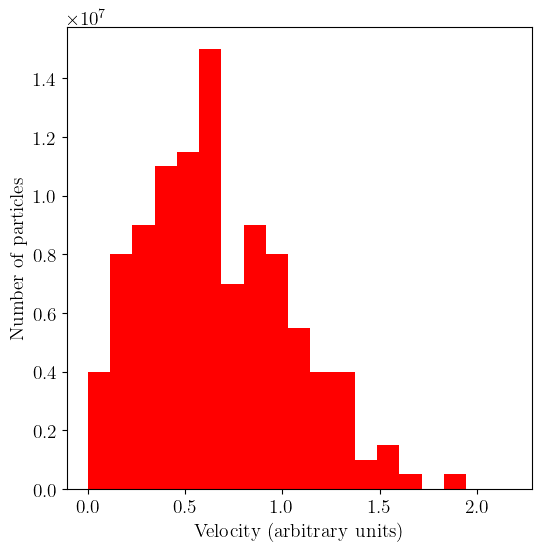

In [194]:
velocity_plotter(velocities[len(velocities)//2:-1])

Define function to create animation of particles.

In [190]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection

def particle_animation(times, positions, nth):
    # nth states only the nth time step is added to the animation
    
    # set up latex labels on plot (optional) 
    rc('text', usetex=True)
    rc('font', size=14)
    rc('legend', fontsize=14)
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})

    # create figure
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    
    # set axis labels
    ax.set_xlabel(r'$x$ (arbitrary units)')
    ax.set_ylabel(r'$y$ (arbitrary units)')
    
    # set axis limits
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_aspect('equal')    
    
    # add text label
    text = ax.text(0.95, 0.05, r'$t = $ '+'{:.3g}'.format(times[0])+' a.u.', ha='right')

    # create animation
    xy = np.asarray(positions)
    anim = FuncAnimation(fig, __animate_frame, frames=len(times[0::nth]), \
                         interval=times[-1]/len(times[0::nth]), \
                         blit=True, fargs=(ax, times[0::nth], xy[0::nth, :, :], text))
    plt.close()
    
    return anim

def __animate_frame(i, ax, times, positions, text):
    
    # remove previous arrow for efficiency
    for child in ax.get_children():
        if isinstance(child, PathCollection):
            child.remove()
    
    # add vector to plot
    ax.scatter(positions[i, :, 0], positions[i, :, 1], c=np.arange(0, len(positions[i, :, 0])))
    
    text.set_text(r'$t = $ '+'{:.3g}'.format(times[i])+' a.u.')
    
    return text,

In [191]:
nth = 10000
anim = particle_animation(times, positions, nth)

In [192]:
f = "particles.html"
writervideo = animation.HTMLWriter(fps=len(times[0::nth])/times[-1])
anim.save(f, writer=writervideo, dpi=100)